In [1]:
import torch
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO
import imageio
from tqdm import tqdm
import numpy as np
from scipy.ndimage import gaussian_filter


## Random seed
seed = 1287632
torch.manual_seed(seed)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
data = np.load("/home/stan/data/pinn/src/0725_forwardwave_slices.npz")["data"]

### Load data to fit

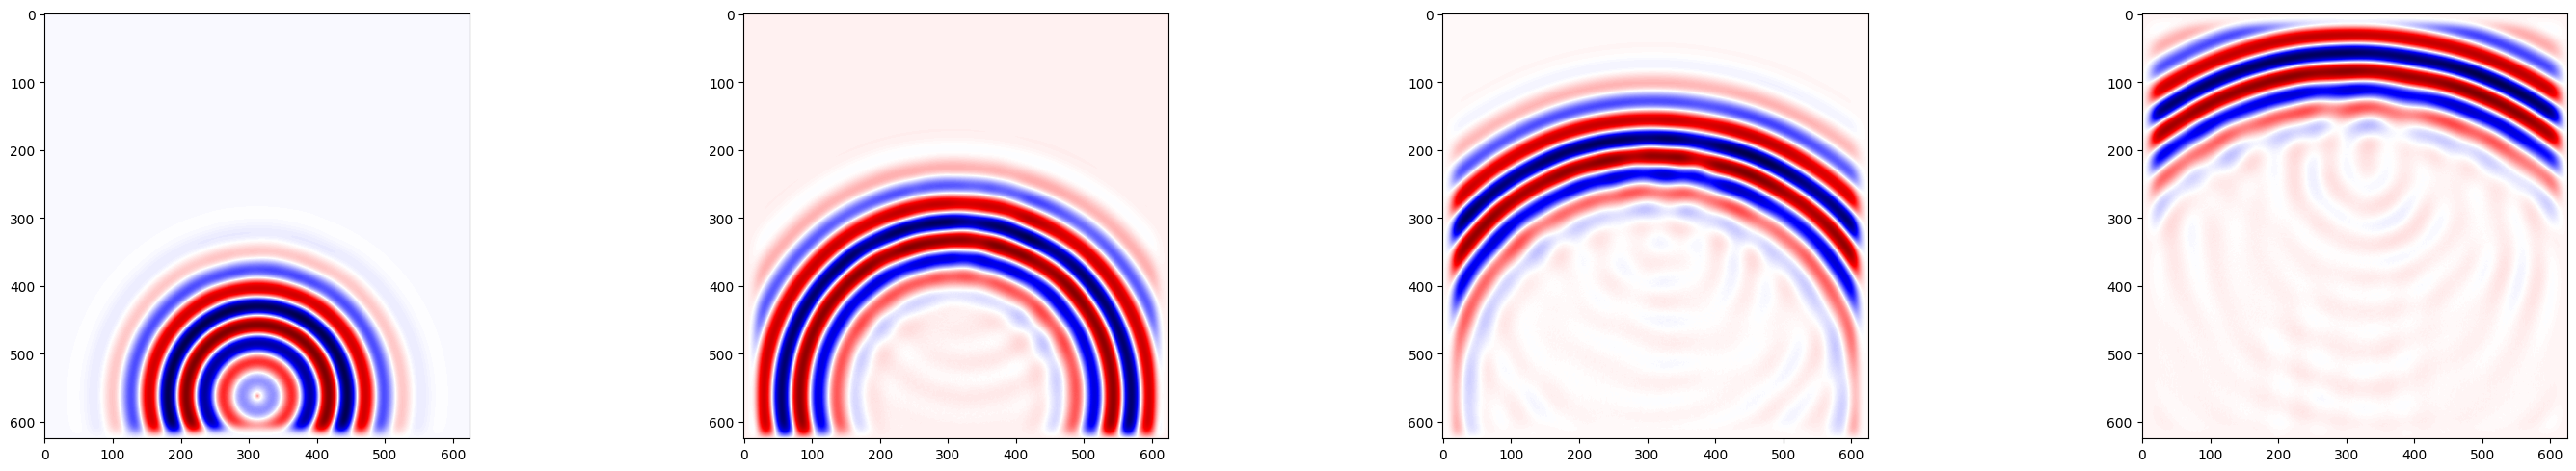

In [2]:
def plot_slices(slices):
    slices_num = slices.shape[0]
    fig, axs = plt.subplots(1, slices_num, figsize=(30, 5)) 
    for i in range(slices_num):
        axs[i].imshow(slices[i], cmap="seismic")
    plt.tight_layout()
    plt.show()

min_val = np.min(data)
max_val = np.max(data)
average = np.mean(data)
slices = (data - min_val) / (max_val - min_val)
plot_slices(slices)
trainset = slices


### Defined input

In [3]:

RES = 625
# x1 = np.linspace(0, 1, RES//2+1)[:-1]
x1 = np.linspace(0, 1, RES+1)[:-1]
x1_t = np.linspace(0, 1, 4+1)[:-1]
x_train = np.stack(np.meshgrid(x1, x1_t,x1), axis=-1) # 3D
print(x_train.shape, x_train)

(4, 625, 625, 3) [[[[0.     0.     0.    ]
   [0.     0.     0.0016]
   [0.     0.     0.0032]
   ...
   [0.     0.     0.9952]
   [0.     0.     0.9968]
   [0.     0.     0.9984]]

  [[0.0016 0.     0.    ]
   [0.0016 0.     0.0016]
   [0.0016 0.     0.0032]
   ...
   [0.0016 0.     0.9952]
   [0.0016 0.     0.9968]
   [0.0016 0.     0.9984]]

  [[0.0032 0.     0.    ]
   [0.0032 0.     0.0016]
   [0.0032 0.     0.0032]
   ...
   [0.0032 0.     0.9952]
   [0.0032 0.     0.9968]
   [0.0032 0.     0.9984]]

  ...

  [[0.9952 0.     0.    ]
   [0.9952 0.     0.0016]
   [0.9952 0.     0.0032]
   ...
   [0.9952 0.     0.9952]
   [0.9952 0.     0.9968]
   [0.9952 0.     0.9984]]

  [[0.9968 0.     0.    ]
   [0.9968 0.     0.0016]
   [0.9968 0.     0.0032]
   ...
   [0.9968 0.     0.9952]
   [0.9968 0.     0.9968]
   [0.9968 0.     0.9984]]

  [[0.9984 0.     0.    ]
   [0.9984 0.     0.0016]
   [0.9984 0.     0.0032]
   ...
   [0.9984 0.     0.9952]
   [0.9984 0.     0.9968]
   [0.9984 0. 

### Define DNN

In [4]:
import torch
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_dim=2, hiddenlayer_dim = 256,output_dim=1):
        super(FNN, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(input_dim, hiddenlayer_dim),
            nn.ReLU(),
            nn.Linear(hiddenlayer_dim, hiddenlayer_dim),
            nn.ReLU(),
            nn.Linear(hiddenlayer_dim, hiddenlayer_dim),
            nn.ReLU(),
        )
        self.l2 = nn.Sequential(
            nn.Linear(hiddenlayer_dim, output_dim),
            nn.Sigmoid(),
        )
    def forward(self, x):
        y = self.l1(x)
        y = self.l2(y)
        return y

### Train

In [5]:
import torch.optim as optim
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
train_dict ={}
gt_rms = np.sqrt(np.mean(trainset**2))

def train_model(trainset , epochs, model_path):
    x = torch.tensor(x_train, dtype=torch.float32).to(device)
    y = torch.tensor(trainset, dtype=torch.float32).to(device)

    model = FNN(input_dim=3, hiddenlayer_dim= 625,output_dim=1)
    mse_loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if model_path:
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict["model"])
        optimizer.load_state_dict(state_dict["optimizer"])
        print(f"model loaded at {model_path}")

    model.to(device)
    model.train()
        
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        output = model(x).squeeze()
        loss = mse_loss_fn(output, y)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            output = output.detach().cpu().numpy()
            plot_slices(output)
            RMSE = np.sqrt(loss.item())
            print(f"Epoch {epoch+1}/{epochs}, MSELoss: {loss.item():.4f}, relative RMSE:{RMSE/gt_rms:.4f}")
            
    train_dict["model"] = model.state_dict()
    train_dict["optimizer"] = optimizer.state_dict()
    train_dict["output"] = output
        
train_model(trainset , epochs=4000, model_path="/home/stan/data/pinn/ckpt/0725_forward4slices.pt")


model loaded at /home/stan/data/pinn/ckpt/0725_forward4slices.pt


  0%|          | 0/4000 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.64 GiB. GPU  has a total capacity of 39.44 GiB of which 577.25 MiB is free. Process 74297 has 636.00 MiB memory in use. Process 497956 has 8.45 GiB memory in use. Process 502555 has 2.28 GiB memory in use. Process 968421 has 4.40 GiB memory in use. Process 3115163 has 3.43 GiB memory in use. Process 1134262 has 2.89 GiB memory in use. Process 4060193 has 846.00 MiB memory in use. Including non-PyTorch memory, this process has 15.96 GiB memory in use. Of the allocated memory 10.97 GiB is allocated by PyTorch, and 3.63 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(train_dict.keys())
torch.save(train_dict, "/home/stan/data/pinn/ckpt/0725_forward4slices.pt")